# Particle Tracking Code

In [2]:
#importing the required modules
import numpy as np #Numerical Python
import scipy #Scientific Python

%matplotlib inline

import mpld3 #For making nice looking plots
#If mpld3 is not available, install with conda (run "conda install mpld3" in Anaconda
# command prompt)

mpld3.enable_notebook()
import matplotlib
from matplotlib import pylab

#For making interactive user interfaces (buttons and sliders and such)
import ipywidgets as widgets
from ipywidgets import Layout, interact, fixed

#Loading the particle tracking software
import sys
##MAC
sys.path.append("..//track") #Locate code
##PC
# sys.path.append("..\\track")
import mpretrack #The file mpretrack.py and trackmem.py should be in the location above
import trackmem
import bpass
import tiff_file #Ignore any warnings importing this may cause
import pickle

..//track\tiff_file.py:1995: UserWarning: failed to import _tifffile.decodepackbits
  warnings.warn("failed to import %s" % module_function)
..//track\tiff_file.py:1995: UserWarning: failed to import _tifffile.decodelzw
  warnings.warn("failed to import %s" % module_function)
..//track\tiff_file.py:1995: UserWarning: failed to import _tifffile.unpackints
  warnings.warn("failed to import %s" % module_function)


In [94]:
data_directory = "Z:\\ChristelleSummer2018\\Data\\BeadsInConditions\\Copolymerized\\2018_07_13\\40\\2018_07_13_Copoly40fps_1\\"
f = open(data_directory+'mt.p','rb')
mt = pickle.load(f)
f.close()
frame_rate = 40.0

In each frame, the code has identified particles (i.e., features). Now we have to link them together into "tracks."


In [95]:
### Tracking with fancytrack:
num_dimensions = 2 #We take 2-dimensional images
max_displacement = 3 #Maximum displacement between consecutive frames to count as same particle
goodenough = 20 #Minimum length for trajectory
memory = 1 #how many consecutive frames a feature is allowed to skip. 
tracks = trackmem.trackmem(mt, max_displacement, num_dimensions, goodenough, memory)

TypeError: 'numpy.float64' object cannot be interpreted as an index

What's in <code>tracks</code>?
+ <code>tracks[:,0]</code> is the *x*-coordinate of particle (in terms of pixel)
+ <code>tracks[:,1]</code> is the *y*-coordinate
+ <code>tracks[:,2]</code> is the integrated brightness of found features
+ <code>tracks[:,3]</code> is the square of the radius of gyration
+ <code>tracks[:,4]</code> is the eccentricity (zero for circularly symmetric features)
+ <code>tracks[:,5]</code> is the frame number
+ <code>tracks[:,6]</code> is the time
+ <code>tracks[:,7]</code> is the trajectory ID number

Let's look at how many trajectories we've found, what the length of some of these trajectories are and what they look like superimposed on an image of the beads.

In [96]:
#The last element in the each "track" is the track ID number. It starts at one. 
# So finding the maximum of the track ID number will tell us how many tracks
# there are. 
print "Number of trajectories: %i" % tracks[:,7].max()

Number of trajectories: 1300


In [97]:
#Just to get a sense of the length of the trajectories.
#Printing the lenghts by funding all instances where the track ID
#  number is 1, 2, 3. 

print "Length of 1st trajectory: %i" % np.sum(tracks[:,7]==1)
if tracks[:,7].max()>1: #this checks to make sure there is a track ID 2
    print "Length of 2nd trajectory: %i" % np.sum(tracks[:,7]==2)
if tracks[:,7].max()>2:
    print "Length of 3rd trajectory: %i" % np.sum(tracks[:,7]==3)

Length of 1st trajectory: 44
Length of 2nd trajectory: 43
Length of 3rd trajectory: 38


In [98]:
track_IDs_Length = np.zeros((int(tracks[:,7].max()),2)) #Array of track ID numbers and length of those tracks
for i in range(1,int(tracks[:,7].max()+1)):
    w = np.where(tracks[:,7]==i)
    track_IDs_Length[i-1,0] = i
    track_IDs_Length[i-1,1] = len(w[0])
        

# Finding the inital diffusion coefficient

In [99]:
num_frames = int(51*frame_rate)
total_sd = np.zeros((num_frames)) #total squared displacements
num_sd = np.zeros((num_frames)) #number of squared displacements
len_cutoff = 10


for i in range(0,len(track_IDs_Length)):
    if track_IDs_Length[i,1]>len_cutoff:
        #Find indices for a given track ID number
        w = np.where(tracks[:,7]==track_IDs_Length[i,0])
        frameIDs = tracks[w[0],5] ##finds the frame numbers for the specified trackID
        xys = tracks[w[0],0:2] #x- and y-positions
        
        
        
        #Loop over delay times
        for j in range(1,xys.shape[0]-1):
            xdiff = xys[j:,0]-xys[0:-1*(j),0] #Vector of displacment in x
            ydiff = xys[j:,1]-xys[0:-1*(j),1] #Vector of displacment in y
            squared_displacement = xdiff**2 + ydiff**2 #Squared displacemnt in x-y plane
            
            #Here, sum the squared displacments and keep track of how many
            # displacements when into the sum. This way we can find the average.
            total_sd[j-1] = total_sd[j-1] + squared_displacement.sum()
            num_sd[j-1] = num_sd[j-1] + len(squared_displacement)


Change the frame rate here:


C:\Users\Student\Anaconda2\lib\site-packages\mpld3\mplexporter\exporter.py:179: UserWarning: Legend element <matplotlib.offsetbox.HPacker object at 0x000000000B9D75F8> not impemented
  warnings.warn("Legend element %s not impemented" % child)


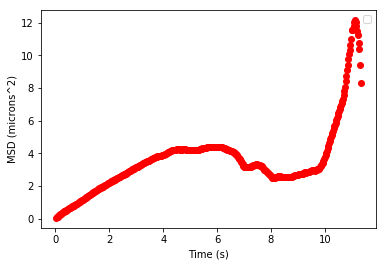

In [103]:
pixel_size = 0.189 #Multiplying by 2 because image was 2x2 binned. This is for 40x on Motic. 
#You may need to adjust pixel size

w = np.where(num_sd>0)
msd = (total_sd[w]/num_sd[w]) * (pixel_size**2)
times = np.arange(1,len(msd)+1)/frame_rate

##Saves the msds as a python file to be used later and as a csv text file for ease of access
save_to = '\\'.join(data_directory.split("\\")[:-2])
pickle.dump(msd, open(save_to + '\\MSD\\msd1.p' , 'wb')) ##this will save to the 
pickle.dump(times, open(save_to + '\\MSD\\times1.p' , 'wb'))
np.savetxt(data_directory+'TimesMsd.txt',np.transpose((times,msd)),delimiter=',')
## pickle.dump(video_number, open(save_to + '\\'+'video_number.p', 'wb')) ##this will save to the fps folder and keep overwriting...


mpld3.enable_notebook()

pylab.plot(times, msd,'ro') #Plot mean-squared displacement versus time with red filled circlesal
pylab.legend() #puts the 'label' on the plot
pylab.xlabel('Time (s)');
pylab.ylabel('MSD (microns^2)');
pylab.savefig(data_directory+'MSDPlot.png')  

In [104]:
np.savetxt(data_dir+'TimesMsd.txt',np.transpose((times,msd)),delimiter=',')
print times[-1]

11.325


0s to 5s
Found diffusion coeff D = 0.2225 (microns^2/s)
Alpha value: 0.8741 
Coefficient value: 1.170 
----------------
5s to 10s
Found diffusion coeff D = -0.1019 (microns^2/s)
Alpha value: -0.8841 
Coefficient value: 19.349 
----------------
5s to 14s
Found diffusion coeff D = 0.1480 (microns^2/s)
Alpha value: 0.4506 
Coefficient value: 1.544 
----------------
10s to 25s
Found diffusion coeff D = 1.6245 (microns^2/s)
Alpha value: 9.7427 
Coefficient value: 0.000 
----------------


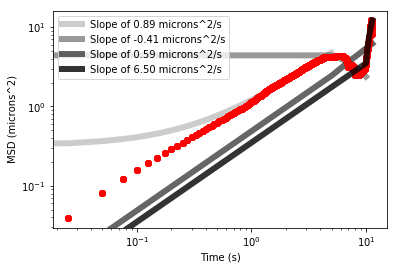

In [105]:
## Getting different diffusion coefficients for different time ranges 
## (0 to 5s, 0 to 10s, 10 to 50s, this is what sylas does)
mpld3.enable_notebook()

cutoff_start =[0,5,5,10]
cutoff_stop = [5,10,14,25]
DiffusionCoeffs = np.empty(len(cutoff_start))
AlphaValues = np.empty(len(cutoff_start))

for p in range(0, len(cutoff_start)):
    start = cutoff_start[p]
    stop = cutoff_stop[p]
   
    x = np.where(times >= start) ## returns indices
    y = np.where(times < stop) ## returns indices
    z = x[0][0]
    zz = y[0][(np.shape(y)[1]-1)]
    K = np.linspace(z,zz,zz-z+1)
    K = K.astype(int)
    
    pylab.loglog(times, msd,'ro') #Plot mean-squared displacement versus time with red filled circles
    linear_fit = np.polyfit(times[K][4:], msd[K][4:],1) #fit to polynomial of order 1 (i.e., a line)
    values_from_fit = np.polyval(linear_fit, np.hstack((np.array([0]),times[K]))) #evaluate polynomial
    pylab.loglog(np.hstack((np.array([0]),times[K])), values_from_fit,
             '-k', lw=6, alpha= .2*(p+1), label = r"Slope of %.2f microns^2/s" % linear_fit[0])
   
    print str(start)+'s to ' + str(stop) + 's'
   # print "Estimate of localization error: %.4f microns" % abs(linear_fit[1])**0.5  ##not sure what this is...is it correct?
    print "Found diffusion coeff D = %.4f (microns^2/s)" % (0.25*linear_fit[0])
    DiffusionCoeffs[p]=0.25*linear_fit[0]
    
    abc = np.where(times < stop)
    efg = np.where(times >= start)
    end = abc[0][-1]
    begin = efg[0][0]
    if (begin < 4):
        begin = 4
        logtimes = np.log(times[begin:end])
        logmsd = np.log(msd[begin:end])
        fit = np.polyfit(logtimes,logmsd,1)
        alphapower = fit[0]
        logx = fit[1]
        k= np.exp(logx)
        print "Alpha value: %.4f " % alphapower
        print "Coefficient value: %.3f " % k
    else:
        logtimes = np.log(times[begin:end])
        logmsd = np.log(msd[begin:end])
        fit = np.polyfit(logtimes,logmsd,1)
        alphapower = fit[0]
        logx = fit[1]
        k= np.exp(logx)
        print "Alpha value: %.4f " % alphapower
        print "Coefficient value: %.3f " % k
       
    AlphaValues[p]= alphapower
    print ("----------------")
pylab.legend() #puts the 'label' on the plot
pylab.xlabel('Time (s)');
pylab.ylabel('MSD (microns^2)');
   
pylab.savefig(data_directory+'\\MSDLogLogPlot.png')  

In [106]:

#Some parameters...
kb = 1.38065e-23  #Boltzmann's constant
t = 298 #temperature in Kelvin
viscosity = 1.002e-3 #8.9e-4 # 1.002 mPa*s
radius = .5e-6
diffusion_coeff = (kb*t)/(6*np.pi*viscosity*radius)*1e6*1e6
est_radius = (kb*t)/(6*np.pi*viscosity*0.25*linear_fit[0]*1e-12)
print "Theoretical D : %.10f" %diffusion_coeff
print "Estimated radius (in nanometers): %.3f nm" % (est_radius*1e9)
print "Estimated diameter (in micrometer): %.3f um" % (est_radius*1e6*2)

Theoretical D : 0.4356733673
Estimated radius (in nanometers): 134.094 nm
Estimated diameter (in micrometer): 0.268 um


In [107]:
pickle.dump(DiffusionCoeffs, open(data_directory + '\\D.p', 'wb'))
pickle.dump(AlphaValues, open(data_directory + '\\AlphaValues.p', 'wb'))